# TDT4173 - Machine Learning
## Final Notebook of project


Students: TESTARD Arthur, VERDON Valentin and VERDIER Nahel

## Contents

0. Imports and variable initialization
1. Data analysis
    - Size analysis, data type, number of features, split into data categories
    - NAN analysis
    - Correlatiosn analysis 
    - #Analyse avec le reshaped

2. Research leads
    - Signal analysis 
    - Signal treatment model with filter and correlations with noises -> Prophet
    - AutoML (keras)
    - #Analyse de la linéarité entre les entrées/sortie
    - #Mettre une étape pour réguler les données simulées par rapport aux données observées 

3. Preprocessing: 
    - Columns selection
    - NANs management
    - Columns creation
    - Normalizations (StandardScaler, Normalizer, RobustScaler, MinMaxScaler)
    - Train/Test split
    - décaler les dates de sortie / entrée (si j’ai le temps diff x_t et x_t-1 pour prédire y_t)

4. Model XGBoost: 
    - Different models testing (RandomForest / LinearRegressor)
    - Hyperparameters study
    - Features importance


## 0. Imports and data initialization

In [95]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
# import networkx as nx
import scipy
import pickle
from datetime import datetime, timedelta

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

In [ ]:
class DataFolder:
    def __init__(self, folder_name: str):
        self.folder_name: str
        self.X_test_estimated: str = f"{folder_name}/X_test_estimated.parquet"
        self.X_train_estimated: str = f"{folder_name}/X_train_estimated.parquet"
        self.X_train_observed: str = f"{folder_name}/X_train_observed.parquet"
        self.train_targets: str | None = f"{folder_name}/train_targets.parquet"

A = DataFolder(folder_name='A')
B = DataFolder(folder_name='B')
C = DataFolder(folder_name='C')

In [ ]:
def read_files(diff_path: str = ''):
    train_a = pd.read_parquet(diff_path + A.train_targets)
    train_b = pd.read_parquet(diff_path + B.train_targets)
    train_c = pd.read_parquet(diff_path + C.train_targets)

    X_train_estimated_a = pd.read_parquet(diff_path + A.X_train_estimated)
    X_train_estimated_b = pd.read_parquet(diff_path + B.X_train_estimated)
    X_train_estimated_c = pd.read_parquet(diff_path + C.X_train_estimated)

    X_train_observed_a = pd.read_parquet(diff_path + A.X_train_observed)
    X_train_observed_b = pd.read_parquet(diff_path + B.X_train_observed)
    X_train_observed_c = pd.read_parquet(diff_path + C.X_train_observed)

    X_test_estimated_a = pd.read_parquet(diff_path + A.X_test_estimated)
    X_test_estimated_b = pd.read_parquet(diff_path + B.X_test_estimated)
    X_test_estimated_c = pd.read_parquet(diff_path + C.X_test_estimated)

    return train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c

## 1. Data analysis

## 2. Research leads

### 1. Signal analysis

Because our data were presenting some periodicities, intuitively, one of our first idea were to analyse the different signals we have, starting by our target, `pv_measurement`. However, as we can see on the following plot, the data is not completly cleared, specially on B and C. We will come back to this point in Preprocessing part.

In [ ]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = read_files()

In [ ]:
def filter_dates_when_constants(df, date_c = 'time', y = 'pv_measurement', delta = { 'days': 3 }):
    df = df.copy()
    mask_y_change = df[y] != df[y].shift(1)

    start_date = None
    end_date = None

    constant_periods = []

    for index, row in df.iterrows():
        if not mask_y_change[index]:
            if start_date is None:
                start_date = row[date_c]
            end_date = row[date_c]
        else:
            if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
                constant_periods.append((start_date, end_date))
            start_date = None
            end_date = None

    if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
        constant_periods.append((start_date, end_date))
    return constant_periods

def delete_date_range_from_df(df, dates, date_c = 'time'):
    df = df.copy()
    c = 0
    for start_date, end_date in dates:
        mask = (df[date_c] >= start_date) & (df[date_c] < end_date)
        df = df[~mask]
    df.reset_index(drop=True, inplace=True)
    return df

delta = { 'hours': 12 * 4}
train_a = delete_date_range_from_df(train_a, filter_dates_when_constants(train_a, delta=delta))
train_b = delete_date_range_from_df(train_b, filter_dates_when_constants(train_b, delta=delta))
train_c = delete_date_range_from_df(train_c, filter_dates_when_constants(train_c, delta=delta))

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(30, 20), sharex=True)

train_a[['time','pv_measurement']].set_index('time').plot(ax=axs[0], title='pv_measurement on location A')
train_b[['time','pv_measurement']].set_index('time').plot(ax=axs[1], title='pv_measurement on location B')
train_c[['time','pv_measurement']].set_index('time').plot(ax=axs[2], title='pv_measurement on location C')

As we said, we then tryied to analys this signal with basic components such as Fourier analysis.

In [ ]:
def get_fft_transforms(train):
    y = train["pv_measurement"].dropna().values
    time_diff = train["time"].diff().mean().total_seconds()
    sampling_rate = 1 / time_diff

    n = len(y)
    freq = np.fft.fftfreq(n, 1 / sampling_rate)
    fft_y = np.fft.fft(y)
    amp_fft_y = np.abs(fft_y)
    phase = np.angle(fft_y)
    return freq, fft_y, amp_fft_y, phase, sampling_rate

In [ ]:
trains = { 'A': train_a.dropna(subset='pv_measurement'), 'B': train_b.dropna(subset='pv_measurement'), 'C': train_c.dropna(subset='pv_measurement') }
locations = trains.keys()

freqs, fft_ys, amp_fft_ys, phases, sampling_rates = [
    { 
        loc: get_fft_transforms(trains[loc])[k] for loc in locations 
    } 
    for k in range(5)]

In [ ]:
plt.figure(figsize=(30, 20))
k = 1
for loc in locations:
    plt.subplot(3, 1, k)
    plt.plot(freqs[loc][:len(freqs[loc])//2], amp_fft_ys[loc][:len(freqs[loc])//2])
    plt.title(f"Spectrum of the pv_measurement at {loc} location")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    k += 1
plt.show()

In [ ]:
plt.figure(figsize=(30, 20))
k = 1
for loc in locations:
    plt.subplot(3, 1, k)
    plt.plot(freqs[loc][:len(freqs[loc])//2], 20 * np.log10(amp_fft_ys[loc][:len(freqs[loc])//2]))
    plt.title(f"Spectrum in magnitude of the pv_measurement at {loc} location")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid()
    k += 1
plt.show()

We then looked on the most important frequencies in those spectrums.

In [ ]:
def print_peak_frequencies(amp_fft_y, freq, threshold, loc):
    peaks, _ = scipy.signal.find_peaks(amp_fft_y[:len(amp_fft_y)//2], height=threshold)
    peak_frequencies = freq[:len(freq)//2][peaks]

    period_size = int(1/peak_frequencies[0])
    continuous_component = np.mean(trains[loc]["pv_measurement"].dropna().values[:period_size])

    print("Location:", loc)
    print(f'Most important periods (in days): \n{1 / peak_frequencies / 3600 / 24}')
    print(f'Value of the continous component: {continuous_component}\n\n')

In [ ]:
thresholds = { 'A': .5e7, 'B': .5e6, 'C': .25e6 }
for loc in locations:
    print_peak_frequencies(amp_fft_ys[loc], freqs[loc], thresholds[loc], loc)

First commentaries:

We know from the analysis of the nan values that A got the most clean datas in term of `pv_measurement` values. So our analysis will mostly be based on what we see on A. We can notice 3 most important frequencies: one for the year, one for the day and one for a half-day (12 hours). If we look more on the frequency plot, we can notice a most little one frequency (that our threshold impeach us to read it on the last print). This seems to be a peak for a period of 8 hours, according to the code cell bellow.

Because B and C are not much clean, we can suppose that the big differencies we found with A comes from the Nan values, which create some empty cells in these frames, which are compensated by increasing the frequency values. However, we did not pay attention to it much at first be because most of our analysis were based on A data.

In [ ]:
freq_a_1 = np.min(np.where(freqs['A'] > .00003)) 
freq_a_2 = np.max(np.where(freqs['A'] < .00004))
freq_arg = np.argmax(fft_ys['A'][:len(fft_ys['A'])//2][freq_a_1:freq_a_2])
1 / freqs['A'][:len(fft_ys['A'])//2][freq_a_1:freq_a_2][freq_arg] / 3600 

We can confirm what we sayied on B and C compared to A if we look on the differents sampling rates depending on the situation. Theorically, it should be close to one hour ($=3600$ seconds) because our values are measured every hours. But if we look on `1 / sampling_rates['B']` and `1 / sampling_rates['C']` we see that it's more than it for B and C locations. This comes from Nan values and confirms our point above.

We can notice that `1 / sampling_rates['B']` is a bit bigger than an hour. We can explain it by the gap of one week between `X_train_observed_a` and `X_train_estimated_a`, which exists as well in `train_a`.

In [ ]:
1 / sampling_rates['A'] / 3600, 1 / sampling_rates['B'] / 3600, 1 / sampling_rates['C'] / 3600

The first thing we can try is to recalculate the model by the inverse of Fourier's transformation.

In [ ]:
i_fft_ys = { loc: np.fft.ifft(fft_ys[loc]) for loc in locations }

plt.figure(figsize=(30, 20))
k = 1
for loc in locations:
    plt.subplot(3, 1, k)
    plt.plot(trains[loc]['pv_measurement'], label='real pv_measurement')
    plt.plot(i_fft_ys[loc], label='ifft pv_measurement')
    plt.title(f"Spectrum of the pv_measurement at {loc} location")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    k += 1
plt.show()

We notice a gap created in C but in facts its due to the index. 

Now the idea is to keep only the most important frequencies in order to have a model which can be written like this:
$$y[n] = \hat{y}[n] + r[n]$$

where $n$ is the index of the output, $y[n]$ is the real value of `pv_measurement` at index $n$ (or time $t$), $\hat{y}[n]$ is the value at index $n$ of the signal filtered predicted by signal analysis and $r[n]$ is the value at index $n$ of the noise created by mostly, the weather, from our inputs `X_train_estimated`, `X_train_observed`, etc. It would be design by a machine learning model. Actually we did not had the time to test this feature entirely, because of a lack of time our goals priotization. So, it is not entirely designed, but we will detail as far as we came to it.

In [ ]:
end_dates = { 'A': '2022-10-21', 'B': '2022-03-15', 'C': '2022-04-01'}
# end_dates = { 'A': X_train_observed_a['date_forecast'].max(), 'B': X_train_observed_b['date_forecast'].max(), 'C': X_train_observed_c['date_forecast'].max() }

start_dates = { 'A': '2020-10-21', 'B': '2020-03-15', 'C': '2020-04-01' }

In [ ]:
def get_model(fft_values, threshold=60, sample_rate=1):

    n = len(fft_values)

    frequencies = np.fft.fftfreq(n, 1 / sample_rate)
    amplitudes = fft_values * (np.abs(fft_values) > threshold)
    phases = np.angle(fft_values)
    return {"frequencies": frequencies, "amplitudes": amplitudes, "phases": phases}

In [ ]:
def reconstruct_signal(model, duration,sample_rate):
    frequencies = model["frequencies"]
    amplitudes = model["amplitudes"]
    phases = model["phases"]

    t = np.arange(0, duration, 1)
    signal = np.zeros(len(t), dtype=np.complex128)
    
    for freq, amp, phase in tqdm(zip(frequencies, amplitudes, phases)):
        signal += amp * np.exp(2j * np.pi * freq * t / sample_rate + phase)
    return signal / len(frequencies)

In [ ]:
def get_thresholds_to_get_n_freq(signal, nb_freq, threshold, step):
    assert step > 0
    fft = np.fft.fft(signal)
    abs_fft = np.abs(fft[:len(fft)//2])

    freqs = [ f for f in abs_fft if f > threshold ]
    threshold += step
    while len(freqs) > nb_freq:
        freqs = [ f for f in abs_fft if f > threshold ]
        threshold += step
    threshold = threshold if len(freqs) > 0 else threshold - step
    return threshold

In [ ]:
def get_filtred_signal(signal, nb_freqs, sample_rate, nb_days_to_predict = 0, threshold = 0, scaler = StandardScaler):
    scaler_pred = scaler
    scaler = scaler()
    Y_normed = scaler.fit_transform(np.array(signal['pv_measurement'].dropna()).reshape(-1, 1)).reshape(-1)

    threshold = get_thresholds_to_get_n_freq(signal=Y_normed, nb_freq=nb_freqs, threshold=0, step=.5)
    model = get_model(fft_values=np.fft.fft(Y_normed), threshold=threshold, sample_rate=sample_rate)
    pred_from_model_data = np.real(reconstruct_signal(model, duration=len(model["frequencies"]) + nb_days_to_predict, sample_rate=sample_rate)) 
    scaler_pred = scaler_pred()
    pred_normed = scaler_pred.fit_transform(pred_from_model_data.reshape(-1, 1)).reshape(-1)

    Y_filtred = scaler.inverse_transform(pred_normed.reshape(-1, 1)).reshape(-1)

    # If we want to filter negative values
    Y_filtred[Y_filtred < 0] = 0
    return Y_filtred

In [ ]:
nb_freqs = 2
nb_days_to_predict = 0

trains_on_dates = { loc: trains[loc][(trains[loc]["time"] < pd.Timestamp(end_dates[loc])) & (trains[loc]["time"] >= pd.Timestamp(start_dates[loc]))] for loc in locations }
Y_filtred = { loc: get_filtred_signal(trains_on_dates[loc], nb_freqs, sampling_rates[loc], nb_days_to_predict=nb_days_to_predict) for loc in locations }

In [ ]:
sp = 1

plt.figure(figsize=(50, 30))
for loc in locations:
    plt.subplot(3, 1, sp)
    plt.plot(Y_filtred[loc], color='b')
    plt.plot(np.array(trains_on_dates[loc]['pv_measurement']), color='orange')
    plt.title(f"Prophet on location {loc}")
    sp += 1

However, we explored different ways to design $\hat{y}[n]$. The first one is a raw filter on the whole signal. This method were not much efficient. In our researchs we found `prophet`, a Python (and R) library which gives a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [ ]:
end_dates = { 'A': X_train_estimated_a['date_forecast'].max(), 'B': X_train_estimated_b['date_forecast'].max(), 'C': X_train_estimated_c['date_forecast'].max() }
trains = { loc: trains[loc][trains[loc]['time'] <= end_dates[loc]] for loc in locations}

prophet_scalers = { loc: MinMaxScaler() for loc in locations }

In [ ]:
trains_raw_prophet = { loc: trains[loc].dropna(subset='pv_measurement').reset_index().rename(columns={'time': 'ds', 'pv_measurement': 'y'}) for loc in locations }

trains_prophet = trains_raw_prophet
for loc in locations:
    trains_prophet[loc]['y'] = prophet_scalers[loc].fit_transform(np.array(trains_raw_prophet[loc]['y']).reshape(-1, 1)).reshape(-1)

models_prophet = { loc: Prophet(changepoint_prior_scale=0.05) for loc in locations }
predictions_prophet = {}
forecast = {}

for loc in locations:
    models_prophet[loc].fit(trains_prophet[loc])
    predictions_prophet[loc] = models_prophet[loc].make_future_dataframe(periods=66, freq='h')
    forecast[loc] = models_prophet[loc].predict(predictions_prophet[loc])

In [ ]:
sp = 1

plt.figure(figsize=(50, 30))
for loc in locations:
    plt.subplot(3, 1, sp)
    plt.plot(trains_prophet[loc]['y'], color='orange')
    plt.plot(forecast[loc]['yhat'], color='b')
    plt.title(f"Prophet on location {loc}")
    sp += 1

This results, from prophet and the filter signal, are not really satisfying. Then came the idea, inpired by [this paper](https://peerj.com/preprints/3190.pdf), to see what's happen if we plot one signal for each hour (it would make $24 * 3 = 72$ models). We then first split our signals by hours and plot what we get with prophet prediction and our filter.

In [ ]:
# USEFULL VALUES TO COMPILE

hours = [ f"0{h}" if h < 10 else str(h) for h in range(24) ]

# end_dates = { 'A': '2022-10-21', 'B': '2022-03-15', 'C': '2022-04-01'}
# start_dates = { 'A': '2020-10-21', 'B': '2020-03-15', 'C': '2020-04-01' }
nb_freqs = 1

In [ ]:
trains_on_dates = { loc: trains[loc][(trains[loc]["time"] < pd.Timestamp(end_dates[loc])) & (trains[loc]["time"] >= pd.Timestamp(start_dates[loc]))] for loc in locations }
trains_on_hours = { loc: { h: trains_on_dates[loc][trains_on_dates[loc]['time'].dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')] for h in hours } for loc in locations }

# MAYBE DROP NA ON B AND C


In [ ]:
Y_h_filtred = { loc: { h: get_filtred_signal(trains_on_hours[loc][h], nb_freqs, sampling_rates[loc] * 24, nb_days_to_predict=nb_days_to_predict, scaler=StandardScaler) for h in hours} for loc in locations }

In [ ]:
for loc in locations:
    sp = 1
    plt.figure(figsize=(50, 30))
    for h in hours:
        plt.subplot(4, 6, sp)
        plt.plot(np.array(trains_on_hours[loc][h]['pv_measurement']), color='orange')
        plt.plot(Y_h_filtred[loc][h], color='b')
        plt.title(f"Filtred signal at time h={h} for location {loc}")
        sp += 1

In [ ]:
def convert_hours_to_days(signal):
    min_len = np.min([len(signal[h]) for h in hours ])
    y_pred = []
    for d in range(min_len):
        for h in hours:
            y_pred.append(signal[h][d])
    return np.array(y_pred)

In [ ]:
Y_h_filtred[loc]['21'].shape

In [ ]:
reconstructed_train = { loc: convert_hours_to_days(Y_h_filtred[loc]) for loc in locations }

In [ ]:
sp = 1

plt.figure(figsize=(30, 20))
for loc in locations:
    plt.subplot(3, 1, sp)
    plt.plot(reconstructed_train[loc], color='b', label='reconstruted from signal analysis')
    plt.plot(np.array(trains_on_dates[loc]['pv_measurement']), color='orange', label='real value')
    plt.title(f"Prophet on location {loc}")
    plt.legend()
    sp += 1

We get here a far more satisfying result. There is a problem for B, we did not get why the curve does not go to 0 value.

In [ ]:
df = { loc: {} for loc in locations }
trains_prophet_on_hours = { loc: { h: trains_prophet[loc][trains_prophet[loc]['ds'].dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')] for h in hours } for loc in locations }

for loc in locations:
    for h in hours:
        date_index = [ (pd.Timestamp(start_dates[loc]) + d).strftime("%Y-%m-%d") for d in [ timedelta(days=k) for k in range(len(trains_prophet_on_hours[loc][h])) ] ]
        trains_prophet_on_hours[loc][h] = pd.DataFrame({'ds': date_index, 'y': trains_prophet_on_hours[loc][h]['y']})


In [ ]:
models_prophet = { loc: { h: Prophet(changepoint_prior_scale=0.05) for h in hours} for loc in locations }
predictions_prophet = { loc: {} for loc in locations }
forecast = { loc: {} for loc in locations }

for loc in locations:
    for h in hours:
        models_prophet[loc][h].fit(trains_prophet_on_hours[loc][h])
        predictions_prophet[loc][h] = models_prophet[loc][h].make_future_dataframe(periods=0, freq='h')
        forecast[loc][h] = models_prophet[loc][h].predict(predictions_prophet[loc][h])

In [ ]:
for loc in locations:
    sp = 1
    plt.figure(figsize=(50, 30))
    for h in hours:
        plt.subplot(4, 6, sp)
        plt.plot(np.array(trains_prophet_on_hours[loc][h].reset_index()['y']), color='orange')
        plt.plot(np.array(forecast[loc][h]['yhat']), color='b')
        plt.title(f"Prophet on location {loc}")
        sp += 1

In [ ]:
# Y_to_reconstruct = { loc: { h: prophet_scalers[loc].inverse_transform(np.array(forecast[loc][h]['yhat']).reshape(-1, 1)).reshape(-1) for h in hours } for loc in locations }
Y_to_reconstruct = { loc: { h: np.array(forecast[loc][h]['yhat']) for h in hours } for loc in locations }
reconstructed_train_prophet = { loc: convert_hours_to_days(Y_to_reconstruct[loc]) for loc in locations }


In [ ]:
sp = 1

plt.figure(figsize=(30, 20))
for loc in locations:
    plt.subplot(3, 1, sp)
    plt.plot(reconstructed_train_prophet[loc], color='b', label='reconstruted from signal analysis')
    plt.plot(np.array(trains_prophet[loc]['y']), color='orange', label='real value')
    plt.title(f"Prophet on location {loc}")
    plt.legend()
    sp += 1

These results are less satisfying than the precedent result. But let's see what happens if we try to predict the noise, $r[n]$, with Prophet.

In [ ]:
noise_prophet = { loc: { h: np.array(trains_on_hours[loc][h]['pv_measurement']) - Y_h_filtred[loc][h] for h in hours } for loc in locations }

In [ ]:
noise_prophet = { loc: { h: np.array(trains_on_hours[loc][h]['pv_measurement']) - Y_h_filtred[loc][h] for h in hours } for loc in locations }


In [ ]:
trains_noise_prophet_on_hours = { loc: {} for loc in locations }

for loc in locations:
    for h in hours:
        date_index = [ (pd.Timestamp(start_dates[loc]) + d).strftime("%Y-%m-%d") for d in [ timedelta(days=k) for k in range(len(noise_prophet[loc][h])) ] ]
        trains_noise_prophet_on_hours[loc][h] = pd.DataFrame({'ds': date_index, 'y': noise_prophet[loc][h]})

models_prophet = { loc: { h: Prophet(changepoint_prior_scale=0.05) for h in hours} for loc in locations }
predictions_prophet = { loc: {} for loc in locations }
forecast = { loc: {} for loc in locations }

for loc in locations:
    for h in hours:
        models_prophet[loc][h].fit(trains_noise_prophet_on_hours[loc][h])
        predictions_prophet[loc][h] = models_prophet[loc][h].make_future_dataframe(periods=0, freq='h')
        forecast[loc][h] = models_prophet[loc][h].predict(predictions_prophet[loc][h])

In [ ]:
for loc in locations:
    sp = 1
    plt.figure(figsize=(50, 30))
    for h in hours:
        plt.subplot(4, 6, sp)
        plt.plot(np.array(noise_prophet[loc][h]), color='orange')
        plt.plot(np.array(forecast[loc][h]['yhat']), color='b')
        plt.title(f"Prophet on location {loc}")
        sp += 1

## 3. Preprocessing

During our study, we explored many ways to pre-process our inputs. Some were compatible to each other, some were not. We are going to present in this part, all we did as pre-process and those we used.

### 3.1.

### 3.2. Normalization

Our data have variable ranges that are quite different from one another. So we're going to do some normalization to solve this problem.

To do this, we're going to use different normalizations, and when we train the model we'll see which normalization corresponds best to our dataset.

The various standardizations used are as follows: StandardScaler, Normalizer, MinMaxScaler from the library sklearn.preprocessing

Here's the typical function we'll use to normalize the data.

Note: it adapts according to the train and test set, since the scaler must be the same for both stages.

In [90]:
def sklearn_z_score_normalize_dataframe(df,return_scaler=False,scaler=None,fit=True):
    """
    Normalizes a DataFrame using z-score normalization (mean and standard deviation) from Scikit-Learn.

    Parameters:
    df (pd.DataFrame): The DataFrame to be normalized.

    Returns:
    pd.DataFrame: The z-score normalized DataFrame.
    """
    if scaler == None :
      # Create a StandardScaler instance
      scaler = StandardScaler()

      # Fit the scaler on the DataFrame and transform the data
      normalized_data = scaler.fit_transform(df)

    else :
      if fit:
        normalized_data = scaler.fit_transform(df)
      else:
        normalized_data = scaler.transform(df)

    # Create a new DataFrame with the scaled data
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

    # retourner le scaler
    if return_scaler :
      return normalized_df,scaler
    return normalized_df

### 3.3. Feature Engineering

Our data is made up of many features.

**Delating Features**:

Some of them are less important than others. We'll take a look at the ranking of feature importance given by our models after training.

For the moment, however, we've chosen to delete the `date_calc` feature, which doesn't seem relevant because we only see it in the *estimated* dataset.

**Creating Features**:

As for the `date_forecast` feature. We saw during the signal processing analysis that this feature contains events that repeat at given periods (years/days), so we're going to split our feature into several sub-features to try and obtain relationships with the target.

We therefore separate according to: *hours, day of the week, season, month, year, day of the year and day of the month*.

**Modification of Features**:

When we explore our data we can see that `sun_azimuth:d` corresponds to the position of the sun in degrees. So we can see that 0 and 360 correspond to the same thing. So we're going to transform this feature using a cosine to make it continuous and consistent with what it represents.


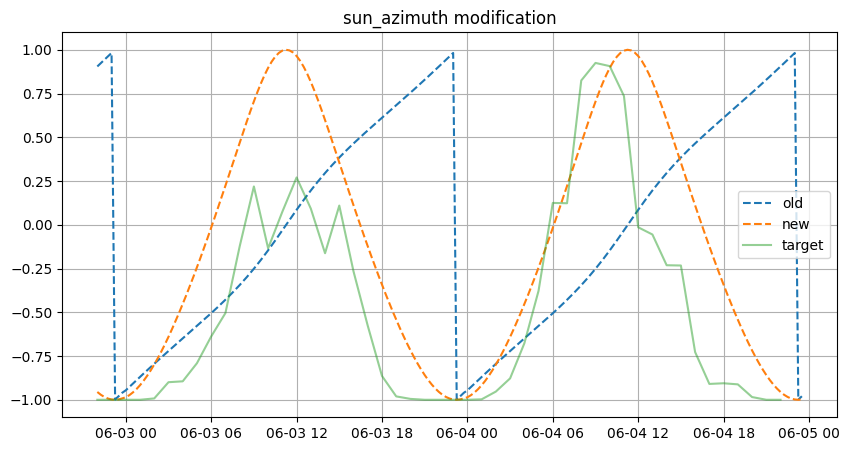

In [91]:
extraction = X_train_observed_a['sun_azimuth:d'][0:199]
transfo = extraction.apply(lambda x : np.cos(x/180*np.pi + np.pi))

plt.figure(figsize=(10,5))
plt.plot(X_train_observed_a['date_forecast'][0:199],extraction/180-1,label="old",ls="--")
plt.plot(X_train_observed_a['date_forecast'][0:199],transfo,label="new",ls="--")
plt.plot(train_a['time'][0:49],train_a["pv_measurement"][0:49]/2500-1,label="target",alpha=0.5)
plt.legend()
plt.grid()
plt.title("sun_azimuth modification")
plt.show()

In [92]:
def create_features(df, label):

    # creating features from dateforecast
    df['hour'] = df["date_forecast"].dt.hour
    df['dayofweek'] = df["date_forecast"].dt.dayofweek
    df['quarter'] = df["date_forecast"].dt.quarter
    df['month'] = df["date_forecast"].dt.month
    df['year'] = df["date_forecast"].dt.year
    df['dayofyear'] = df["date_forecast"].dt.dayofyear
    df['dayofmonth'] = df["date_forecast"].dt.day

    # Deleting date_calc and date_forecast
    df = df.drop(["date_calc","date_forecast"],axis=1) if "date_calc" in df.columns else df.drop(["date_forecast"],axis=1) # date de calcul des estimated inutil pour l'instant

    # Modification of sun_azimuth
    df['sun_azimuth:d'] = df['sun_azimuth:d'].apply(lambda x : np.cos(x/180*np.pi + np.pi))

    # return the target if necessary
    if label:
        y = df[label]
        df = df.drop(label,axis=1)
        return df, y
    return df

### 3.4 Management of constant parts of pv_measurement on B and C

If we look closely at the shape of pv_measurement on B and C, we can see that there are certain sections during which the feature doesn't vary even at night when it should.

We therefore assume that these are erroneous measurements that need to be removed.

In [ ]:
def filter_dates_when_constants(df, date_c = 'time', y = 'pv_measurement', delta = { 'days': 3 }):
    df = df.copy()
    mask_y_change = df[y] != df[y].shift(1)

    start_date = None
    end_date = None

    constant_periods = []

    for index, row in df.iterrows():
        if not mask_y_change[index]:
            if start_date is None:
                start_date = row[date_c]
            end_date = row[date_c]
        else:
            if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
                constant_periods.append((start_date, end_date))
            start_date = None
            end_date = None

    if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
        constant_periods.append((start_date, end_date))
    return constant_periods

In [ ]:
def delete_date_range_from_df(df, dates, date_c = 'time'):
    df = df.copy()
    c = 0
    for start_date, end_date in dates:
        mask = (df[date_c] >= start_date) & (df[date_c] < end_date)
        df = df[~mask]
    df.reset_index(drop=True, inplace=True)
    return df

In [ ]:
# minimum duration
delta = { 'hours': 12 * 4}

# list of these
filter_dates_when_constants(train_b, delta=delta)

In [ ]:
# Deletion B
train_b_delete = delete_date_range_from_df(train_b, filter_dates_when_constants(train_b, delta=delta))
plt.figure(figsize=(10,5))
plt.scatter(train_b_delete["time"],train_b_delete["pv_measurement"],s=0.2)
plt.grid()
plt.title("B without constant periods")
plt.show()

# Deletion C
train_c_delete = delete_date_range_from_df(train_c, filter_dates_when_constants(train_c, delta=delta))
plt.figure(figsize=(10,5))
plt.scatter(train_c_delete["time"],train_c_delete["pv_measurement"],s=0.2)
plt.grid()
plt.title("C without constant periods")
plt.show()

### 3.5. Interpolation of the output

One of our idea, which worked pretty well, was to interpolate the values of the output. We tryed different interpolations, but the one which looked as the best one to do so, were the linear one. It's mathically defined as following, and the function which do the job, is `interpolate_output_values`.$$y(t + 1/4) = 0.75 * y(t) + 0.25 * y(t+1)$$
$$y(t + 1/2) = 0.5 * y(t) + 0.5 * y(t+1)$$
$$y(t + 3/4) = 0.25 * y(t) + 0.5 * y(t+1)$$
where t is a round hour (such as 12:00:00, 13:00:00 etc).

In [45]:
interpolation_method = 'linear'
def interpolate_output_values(df):
    freq = '15T'
    df = df.set_index('time').resample(freq).asfreq()
    df['pv_measurement'] = df['pv_measurement'].interpolate(method=interpolation_method)
    df = df.reset_index()
    return df

In [60]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = read_files()

In [61]:
train_a_interpolated = interpolate_output_values(train_a)
train_b_interpolated = interpolate_output_values(train_b)
train_c_interpolated = interpolate_output_values(train_c)

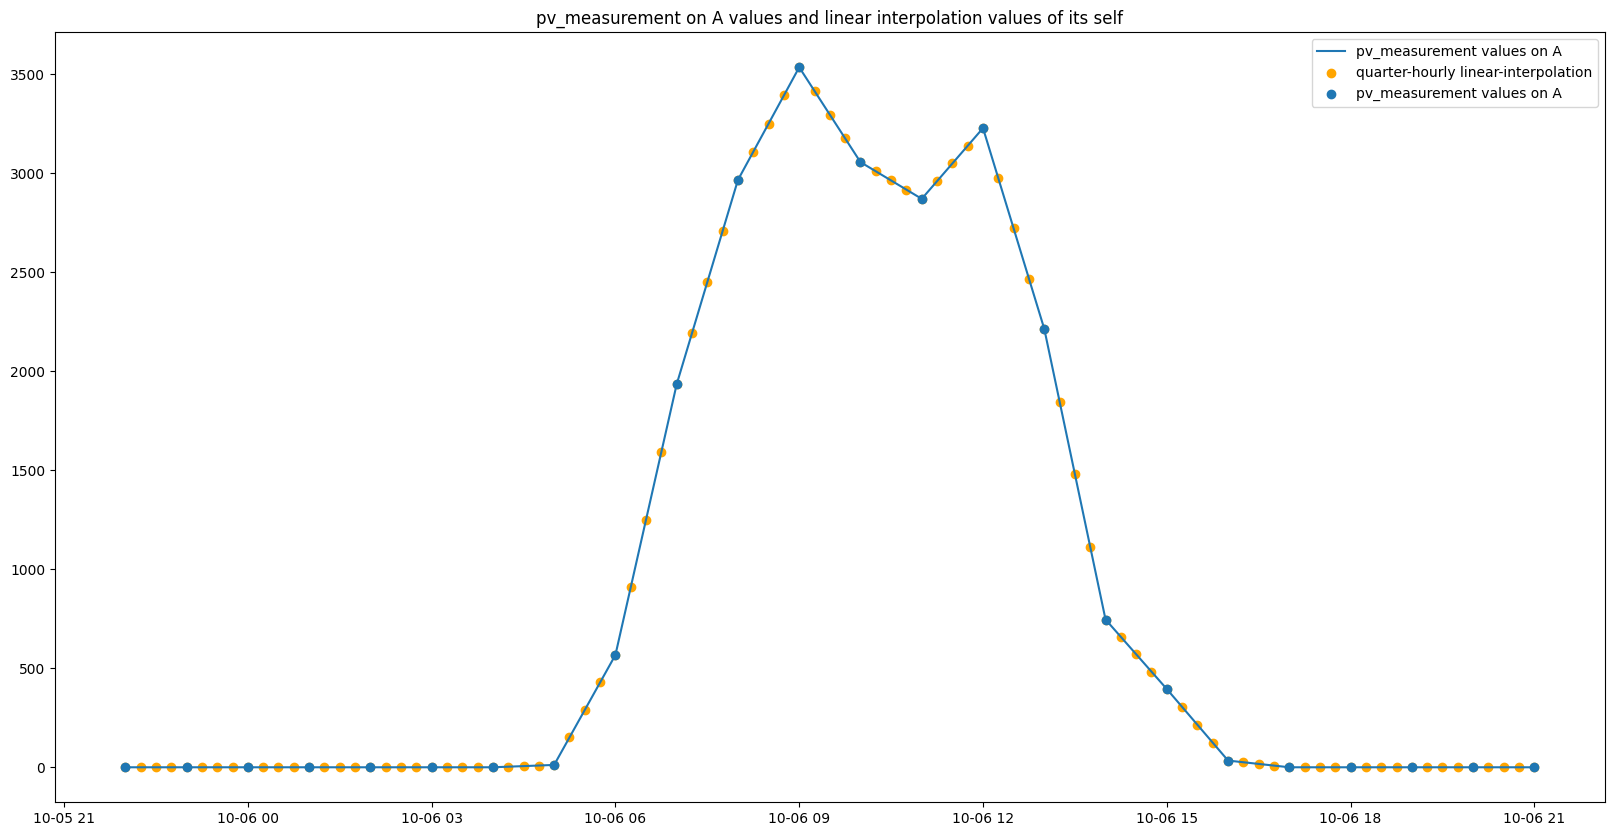

In [85]:
basic_range = train_a['time'].loc[3000:3023].index
interpolation_range = train_a['time'].loc[4 * 3000: 4 * 3023].index
plt.figure(figsize=(20,10))
plt.plot(train_a['time'][basic_range], train_a['pv_measurement'][basic_range], label='pv_measurement values on A')
plt.scatter(train_a_interpolated['time'][interpolation_range], train_a_interpolated['pv_measurement'][interpolation_range], color='orange', label='quarter-hourly linear-interpolation')
plt.scatter(train_a['time'][basic_range], train_a['pv_measurement'][basic_range], label='pv_measurement values on A')
plt.title('pv_measurement on A values and linear interpolation values of its self')
plt.legend()

This interpolation permit us to create 4 times more data, on every location, which are, in a restrective way, similar to the original curve.

### 3.6. Input reshaping

We also thought about some ways to see from a different point of view the data. One was to create more inputs from the data of the past hour. Firstly, we had to select which one of the 4 lines is the most important one to predict the output. We suggested that the solar panel were quite reactive, which means that, for every hours, we have to take into consideration the value of the current hour. It means, for example, at anyday, for an output at the 12:00:00, we have to consider the values from X at 12:00:00. And, because we want to consider what happened during the last hour, we had, as new columns, the values at 11:15:00, 11:30:00 and 11:45:00. The code to create a such matrix is defined as `reshape_frame_to_match_output` (our advise is to not run this function because it require a lot of time to reshape the inputs, we recognize that its not much optimized). 

We had to take some others assumptions into consideration as well. For example, we have in the estimated-testing sets, the time line is not continuous. For example, some days are skipped, so we designed it such as, it duplicate the value of 23:45:00 every days (in order to not get nan values), and the input at 00:00:00 are taken 4 times every days. We considered that, that point was not much important to duplicate the data, because the sun's data are nill (there is no sun during the night as far we experimented it yet), so it should not influence much the result.

In [86]:
from datetime import datetime

def reshape_frame_to_match_output(frame_input):
    frame = frame_input[1:]
    groups = [frame[i:i+4] for i in range(0, len(frame), 4)]

    aggregated_groups = []
    
    first_input = pd.DataFrame(frame_input.loc[0])

    group = pd.concat([first_input, first_input, first_input, first_input])
    group_without_nan = group.fillna('')
    new_input = group_without_nan.stack().reset_index(drop=True)
    aggregated_groups.append(new_input)     
    
    for group in tqdm(groups):
        if (len(np.array(group['date_forecast'])) > 3):
            if ((np.array(group['date_forecast']))[3].astype(datetime).time() == datetime(year=1970, month=1, day=1, hour=0, minute=0, second=0).time()):
                group.reset_index(drop=True, inplace=True)
                temp_group = group.loc[3]
                group.loc[3] = group.loc[2]

                group_without_nan = group.fillna('')
                new_input = group_without_nan.stack().reset_index(drop=True)
                aggregated_groups.append(new_input)

                group.loc[0] = temp_group
                group.loc[1] = temp_group
                group.loc[2] = temp_group
                group.loc[3] = temp_group

                group_without_nan = group.fillna('')
                new_input = group_without_nan.stack().reset_index(drop=True)
                aggregated_groups.append(new_input)
            else:
                group_without_nan = group.fillna('')
                new_input = group_without_nan.stack().reset_index(drop=True)
                # if group == groups[0]: print(len(new_input))
                aggregated_groups.append(new_input)
        else:
            group.reset_index(drop=True, inplace=True)
            for k in range(4 - len(group)):
                group = pd.concat([group, pd.DataFrame(group.loc[len(group) - 1]).T], ignore_index=True)
            group_without_nan = group.fillna('')
            new_input = group_without_nan.stack().reset_index(drop=True)
            aggregated_groups.append(new_input)
            
    new_table = pd.concat(aggregated_groups, axis=1, ignore_index=False).T

    columns = []
    for k in range(4):
        [columns.append(f"{c}_{k}") for c in frame.keys()]

    new_table.columns = columns
    new_table.reset_index(drop=True, inplace=True)
    return new_table

The function is called and run the following way (in comment because it takes to much time to run). We also added a function to save this dataframes to not have to run it everytimes.

In [ ]:
# X_train_estimated_a_reshaped = reshape_frame_to_match_output(X_train_estimated_a)
# X_train_observed_a_reshaped = reshape_frame_to_match_output(X_train_observed_a)
# X_test_estimated_a_reshaped = reshape_frame_to_match_output(X_test_estimated_a)

# X_train_estimated_b_reshaped = reshape_frame_to_match_output(X_train_estimated_b)
# X_train_observed_b_reshaped = reshape_frame_to_match_output(X_train_observed_b)
# X_test_estimated_b_reshaped = reshape_frame_to_match_output(X_test_estimated_b)

# X_train_estimated_c_reshaped = reshape_frame_to_match_output(X_train_estimated_c)
# X_train_observed_c_reshaped = reshape_frame_to_match_output(X_train_observed_c)
# X_test_estimated_c_reshaped = reshape_frame_to_match_output(X_test_estimated_c)

In [87]:
# files_names = ['X_train_estimated.parquet', 'X_train_observed.parquet', 'X_test_estimated.parquet']
# folders = [ f"{loc}_reshaped/" for loc in locations ]
# X_reshaped = [ X_train_estimated_a_reshaped, X_train_observed_a_reshaped, X_test_estimated_a_reshaped, X_train_estimated_b_reshaped, X_train_observed_b_reshaped, X_test_estimated_b_reshaped, X_train_estimated_c_reshaped, X_train_observed_c_reshaped, X_test_estimated_c_reshaped]

# for folder in folders:
#     for file in files_names:
#         index_in_X = (files_names.index(file) + 1) * (folders.index(folder) + 1) - 1
#         X_reshaped[index_in_X].replace('', np.nan).to_parquet(folder + file)

## 4. Pre-prossing ideas that didn't work

### 4.1 Polynomial Features

In order to find new relationships between features, we're going to apply a method called `Polynomial Features`, which consists of adding new features to the dataset that are the products of those already present.

In our dataset, we currently have over 50 features. We can't take all the combinations, as too many features would prevent the model from finding good combinations (with very long training times). So we're going to run a first model without `Polynomial Features` to get a ranking of the importance of the features, so as to take only a certain number. This is what the `recup_var` function does.

We then add to our dataframe the polynomial combinations of these features to the desired degree.

In [93]:
def recup_var(reg,number=10):
  feature_importance = reg.get_booster().get_fscore()
  sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
  top_features = [feature for feature, _ in sorted_feature_importance[:number]]
  return top_features

In [94]:
def column_filter(df,columns):
  df_filtre = df[columns]
  return df_filtre

In [ ]:
def creation_df_polynomial_feature(df,degre=1):

  # Creation of a PolynomialFeatures object
  poly = PolynomialFeatures(degre, include_bias=False)

  # Apply the polynomial caractéristiques to the datas
  poly_features = poly.fit_transform(df)

  # Create a new dataframe
  poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(input_features=df.columns))

  return poly_df

Unfortunately, the results obtained by testing several combinations of features did not improve the score. We therefore decided to shelve this avenue.

If you'd like to implement it and test it with our code, all you have to do is train a model and put it into the recup_var function, then retrieve the filtered dataframe with the filter_column function. Finally, just put it into the creation_df_polynomial_feature function.

### 4.2. Mean of features

We have seen that dataframes containing features are sliced by quarter-hour, whereas those containing targets are sliced by hour.

To try and take into account what happens in the hour as weather (as it impacts `pv_measurement`), we tried to take the average of the different weather components in the hour.

Please note that in the test file, the days are taken at random and we start our predictions at 0h, so we need to take this into account. This is why our code will follow the following algorithm every 24h:
* take the weather at 0h
* remove the weather at 0h and 23h15/30/45
* add the average weather for the 4 lines every 4 lines

In [ ]:
def traitement_df(df_input):

    if "date_calc" in list(df_input.columns):
      df_input = df_input.drop(["date_calc"],axis=1)

    # Initialiser un DataFrame de sortie
    df_output = pd.DataFrame(columns=df_input.columns)

    aux = df_input[df_input.index % 4 == 0]
    date_col = aux["date_forecast"]
    date_col.reset_index(drop=True, inplace=True)

    df_input = df_input.drop(["date_forecast"],axis=1)

    for i in range(0, len(df_input), 96):
        df_etude = df_input.iloc[i:i+96]

        first_row = df_etude.iloc[0]
        df_output = pd.concat([df_output, first_row.to_frame().transpose()], ignore_index=True)

        df_etude = df_etude.iloc[1:-3]
        df_etude.reset_index(drop=True, inplace=True)

        means = df_etude.groupby(df_etude.index // 4).mean()
        df_output = pd.concat([df_output, means], ignore_index=True)

    df_output["date_forecast"] = date_col

    return df_output

## 5. XGBoost